In [3]:
import galarp as grp
grp.pyplot_style()
cmap = grp.lavender_cmap(step_1=50)

import numpy as np

from astropy import units as u

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from gala.units import galactic

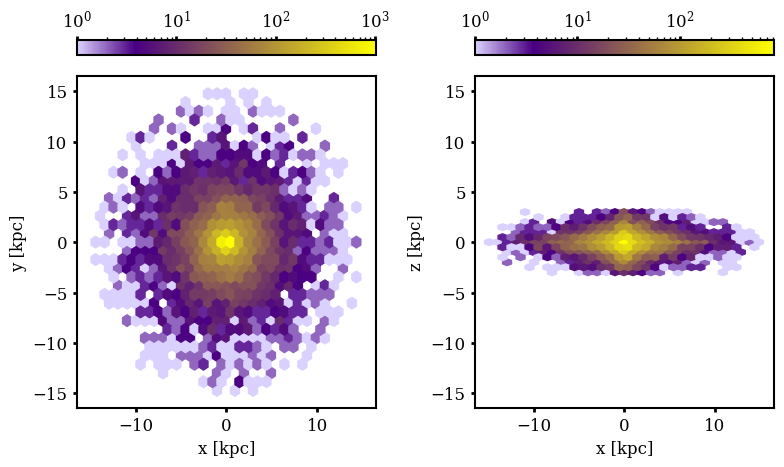

In [4]:
jz2023_satellite = grp.builtins.JZ2023_Satellite()
mass_profile = grp.gen_mass_profile(jz2023_satellite)

particles = grp.ExponentialGrid(h_R=jz2023_satellite["gas"].parameters["a"],
                                h_z=jz2023_satellite["gas"].parameters["b"],
                                n_particles=10000)

particles.generate(mass_profile=mass_profile, positions="temp/positions.npy")

particles.plot_density(cmap=cmap, gridsize=30)

# particles = grp.UniformGrid(n_particles=50)
# particles.generate(mass_profile=mass_profile)

In [5]:
particles = grp.UniformGrid(n_particles=150, Rmax=10)
particles.generate(mass_profile=mass_profile)

In [11]:
inc = 45
wind = grp.StepFunctionWind(t0=200 * u.Myr, units=galactic)
wind.init_from_inc(inclination=np.deg2rad(inc), strength= 1200 * u.km/u.s)

shadow = grp.UniformShadow(damping=0.4, R_disk=3*jz2023_satellite["gas"].parameters["a"],
                           zmin=0.5 * u.kpc, dynamic=True, debug=True)
shadow.init_from_wind(wind)



In [26]:
print(shadow.R_disk, shadow.zmin, shadow.dynamic_shadow)

2.3366627988484288 0.5 True


In [12]:
sim = grp.RPSim(wind=wind, potential=jz2023_satellite, shadow=shadow)
orbits = sim.run(particles, rho_icm=1e-27 * u.g/u.cm**3, integration_time=2000 * u.Myr, dt=5*u.Myr)

--------------------------------------------------------------------------------
------ Running GALA sim with  1.23e+00 kpc / Myr  wind at  0.79  degrees -------
------- Running for 2000.0 Myr  at a timestep of  5.0 Myr  (400.0 steps) -------
--------------------------------------------------------------------------------
---------------------- Container contains 10000 particles ----------------------
- Each cloud has a mass of  1.0e+05 solar masses  and a radius of  50.00 pc   --
------------- This corresponds to a density of 5.41e-23 g / cm3   --------------
--------------------------------------------------------------------------------


100%|██████████| 399/399 [00:07<00:00, 54.20it/s]


In [7]:
# grp.k3d_plot([orbits], outname="temp/orbits.html", duration=60)

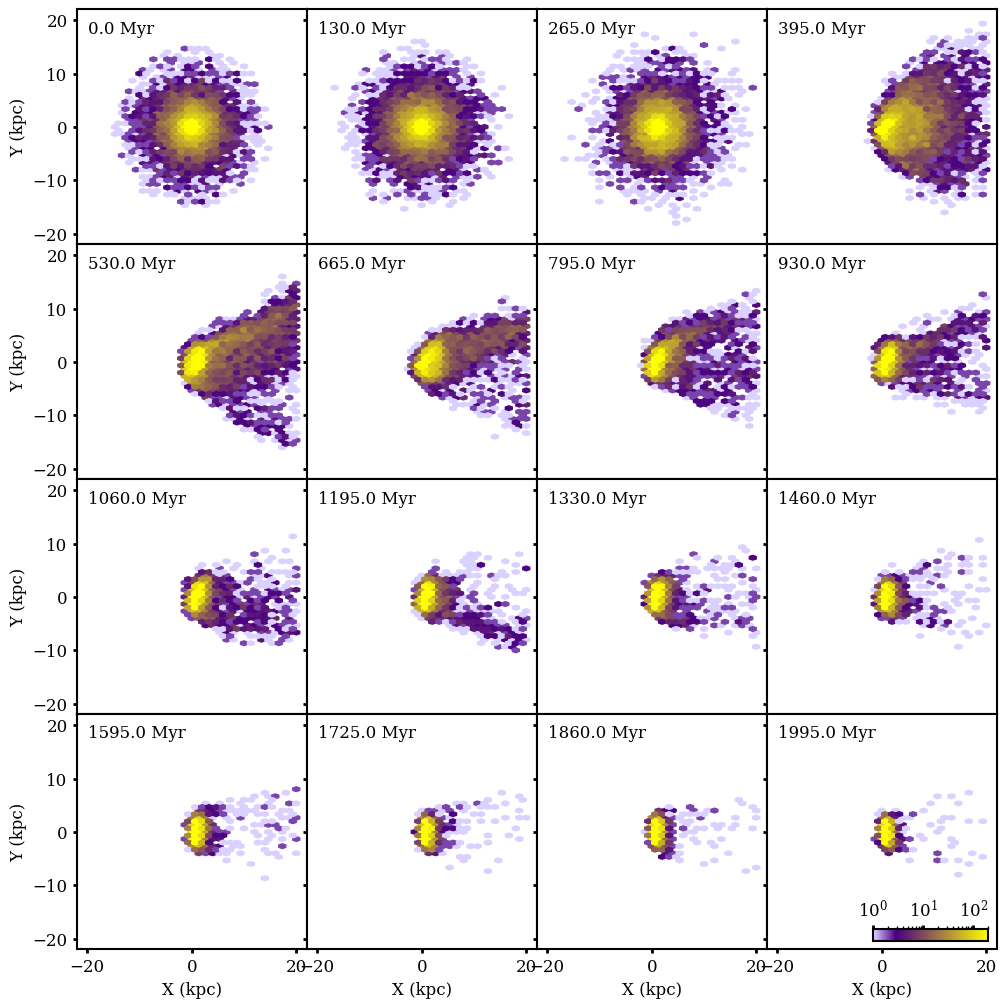

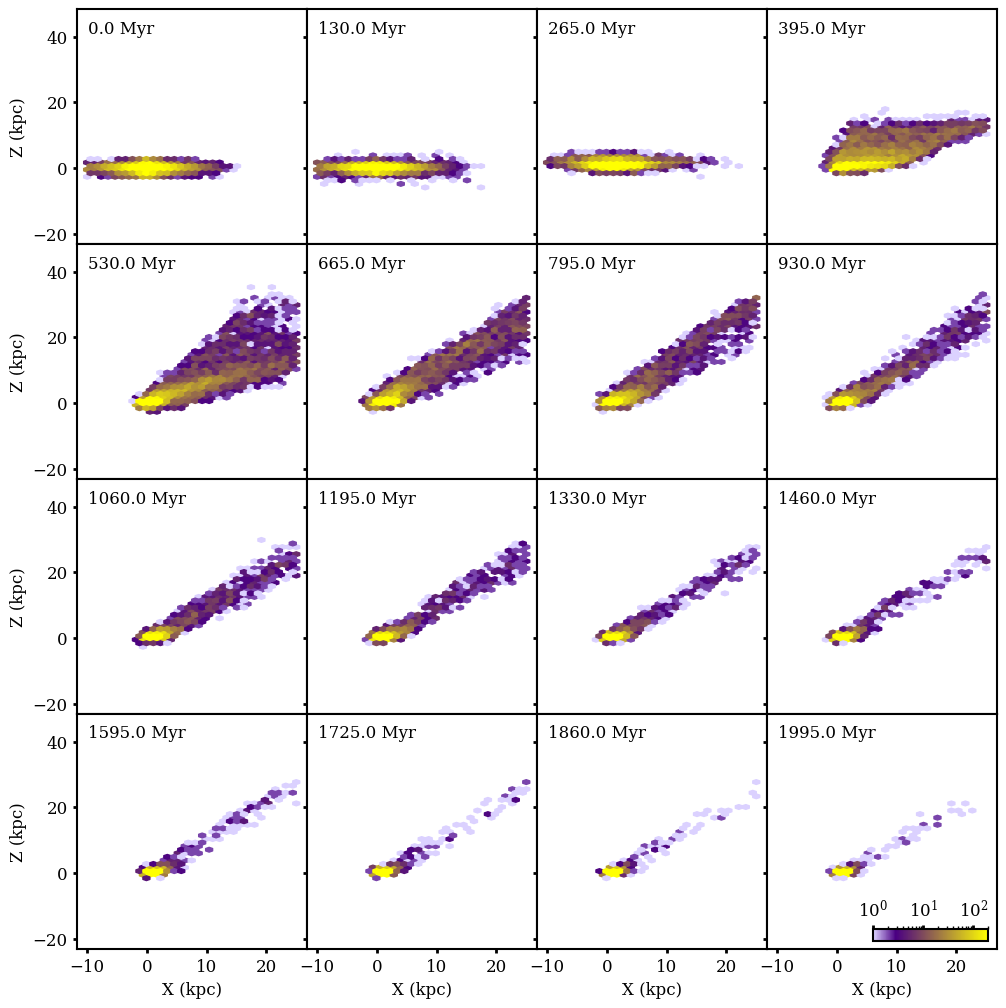

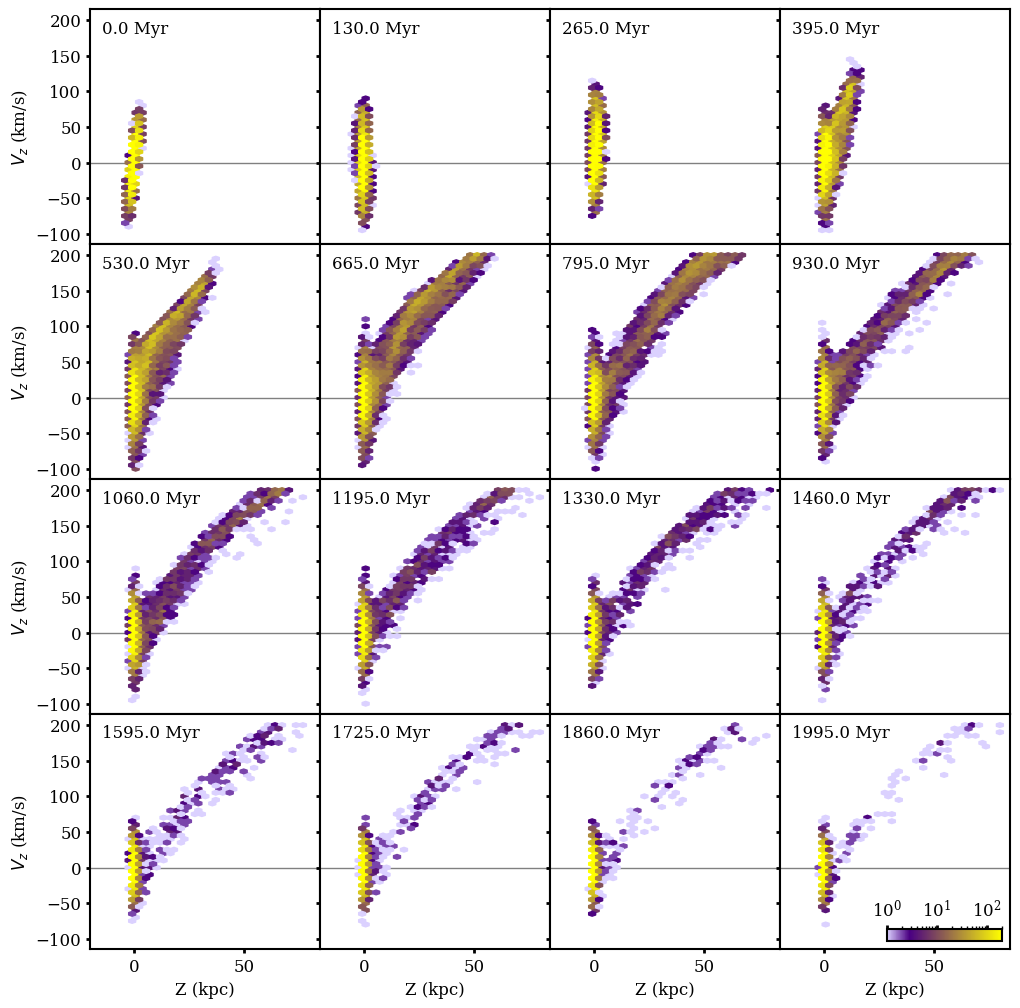

In [8]:


grp.density_matrix(orbits, xextent=20, yextent=20, outname="figures/density_xy_matrix.png", cmap=cmap, vmax=200,
                   cbar_loc="lower right")

grp.density_matrix(orbits, y_ind=2, ylabel = "Z (kpc)", xextent=(-10, 25), yextent=(-20, 45), 
                   outname="figures/density_xz_matrix.png", cmap=cmap, vmax=200, cbar_loc="lower right")

grp.density_matrix(orbits, x_ind=2, y_ind=5, 
                   xlabel="Z (kpc)", ylabel=r"$V_z$ (km/s)",
                   xextent=(-15, 80), yextent=(-100, 200),
                   outname="figures/density_zvz_matrix.png", cmap=cmap, vmax=200,
                   cbar_loc="lower right", hlines=[0])


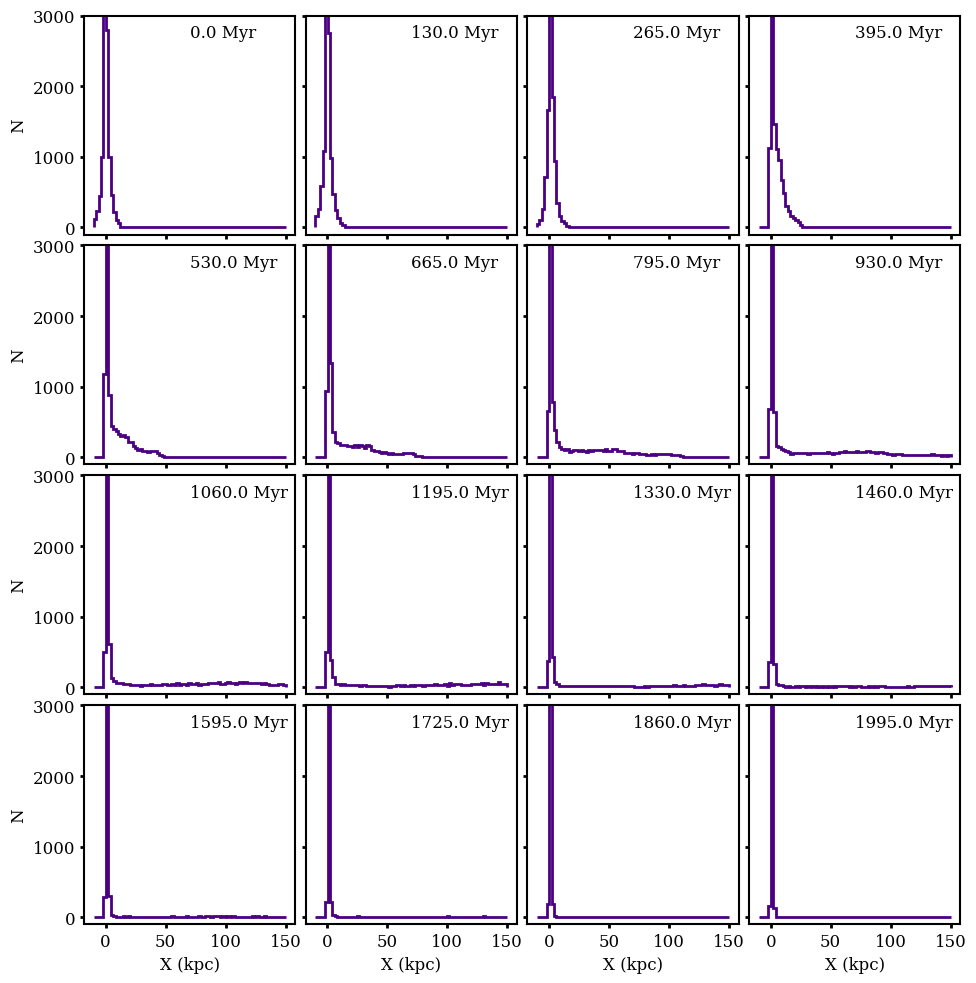

In [9]:
def hist_matrix(orbits, index=0, labels = ["x,y,z"], nrows=4, ncols=4, outname=None, **kwargs):
    times = kwargs.get("times", np.linspace(0, len(orbits.data.t) - 1, nrows * ncols).astype(int))
    xbins = kwargs.get("xbins", np.linspace(-10, 150, 80))

    xlabel=kwargs.get("xlabel", "X (kpc)")
    ylabel=kwargs.get("ylabel", "N")

    ylims = kwargs.get("ylims", (-100, 3000))

    color = kwargs.get("color", "black")
    
    mplot = grp.MatrixPlot(sharex=True, sharey=True, **kwargs)
    fig, ax = mplot.create()

    data = grp.get_orbit_data(orbits.data)

    x = data[index]

    index = 0
    def method(i, j, index, x):
        this_x = x.T[times[index]]

        ax[i, j].hist(this_x, bins=xbins, color=color, fill=False, histtype='step', lw=2)

        ax[i, j].set_ylim(ylims)
        xmin, xmax = ax[i, j].get_xlim()
        ymin, ymax = ax[i, j].get_ylim()
        dx, dy = xmax - xmin, ymax - ymin
        
        ax[i, j].text(xmax - dx/2, ymax - dy/10, f'{orbits.data.t[times[index]]}')

    mplot.populate(method, x)
    mplot.add_xy_labels(xlabel, ylabel)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.05, wspace=0.05)

    if outname is not None:
        plt.savefig(outname)
    else:
        plt.show()

hist_matrix(orbits, outname="figures/hist_matrix.png", color="indigo")

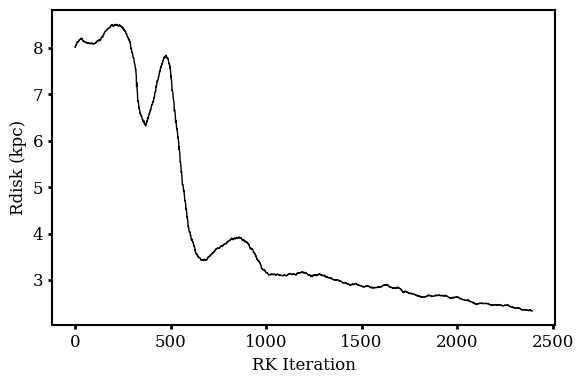

In [21]:
plt.figure(figsize=(6, 4))
plt.plot(shadow.Rdisks, color="black")
plt.xlabel("RK Iteration")
plt.ylabel("Rdisk (kpc)")
plt.tight_layout()
plt.savefig("figures/shadow_rdisk_evolution.png")